In [45]:
#%% Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure, io
from sklearn.linear_model import LinearRegression

# Import "local" packages
import hyspec_io, image_render, preprocess 

In [46]:
#%% Paths
# im_file = Path('/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_81-Crop Wavelengths.bip.hdr')
# test_im_file = ('/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_73-Crop Wavelengths.bip.hdr')

im_file = Path('/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_73-Crop Wavelengths.bip.hdr')
test_im_file = ('/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_81-Crop Wavelengths.bip.hdr')


In [47]:
#%% Parameters
nir_band = (780,840)   # Indices for upper and lower wavelengths in NIR band
vis_band = (350,750)   # Indices for upper and lower wavelengths in VIS band

In [48]:
#%% Import data
(im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(im_file)
im_test,_,_,metadata_test = hyspec_io.load_envi_image(test_im_file)
# (im_train_raw,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(train_raw_file)
# (im_train,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(train_file)
# (im_test,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(test_file)

wl, rgb_ind and metadata are overwritten at each new import. Only the data for the test file is retained.

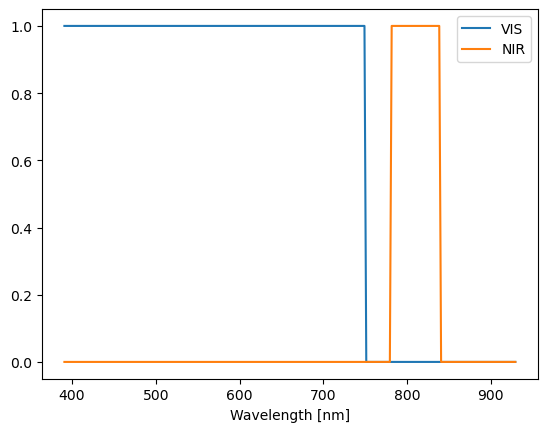

In [49]:
#%% Calc VIS and NIR indices
vis_ind = (wl >= vis_band[0]) & (wl <= vis_band[1])
nir_ind = (wl >= nir_band[0]) & (wl <= nir_band[1])
plt.plot(wl,vis_ind,label='VIS')
plt.plot(wl,nir_ind,label='NIR')
plt.xlabel('Wavelength [nm]')
plt.legend()
plt.show()

In [50]:
# Extract images based on indices
im_vis = im[:,:,vis_ind]
im_nir = np.mean(im[:,:,nir_ind],axis=2,keepdims=True)   # Average to improve SNR

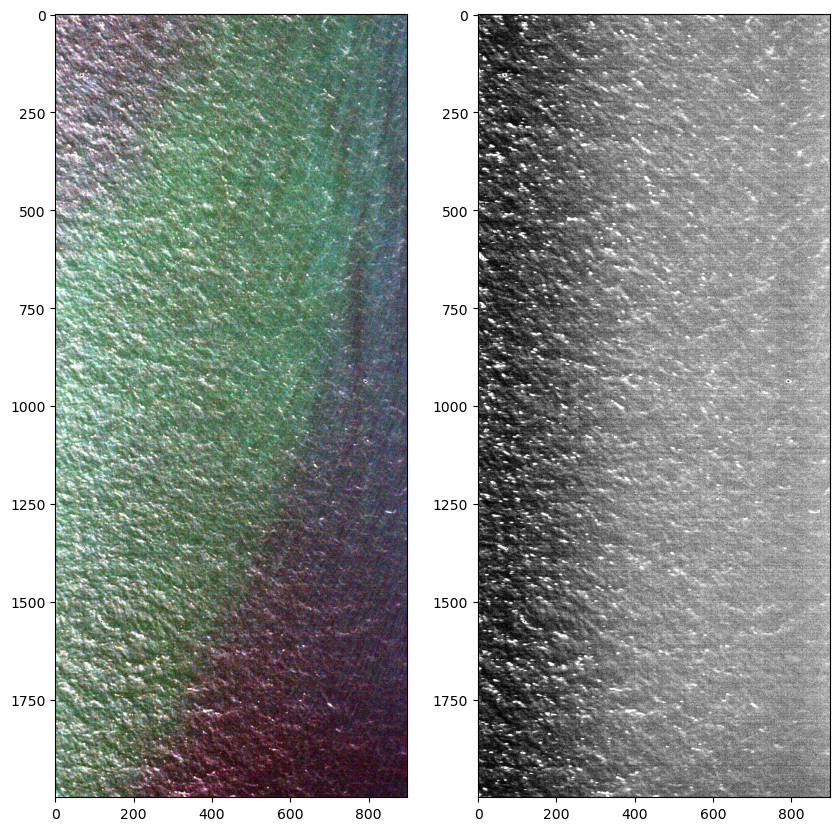

In [51]:
#%% Show RGB and NIR images 
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_nir,separate_bands = False),cmap='gray')
plt.show()

In [52]:
train_vis = im_vis[0:500].reshape((-1,im_vis.shape[2]))
train_nir = im_nir[0:500].reshape((-1,1))

print(train_vis.shape)
print(train_nir.shape)


(450000, 173)
(450000, 1)


In [53]:
#%% Fit a multi-output linear regression model using NIR as X and each individual VIS channel as y
reg = LinearRegression().fit(train_nir,train_vis)

In [54]:
#%% Set intercepts to zero
reg.intercept_ = np.zeros(reg.intercept_.shape)

In [55]:
im_glint = reg.predict(im_nir.reshape((-1,im_nir.shape[2])))
im_glint = im_glint.reshape(im_vis.shape)
print(im_glint.shape)

(2000, 900, 173)


In [56]:
im_noglint = im_vis - im_glint

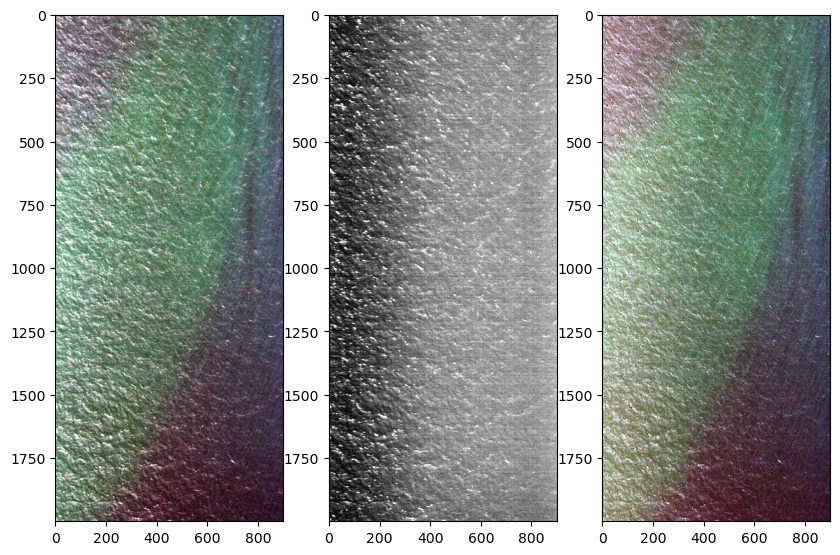

In [57]:
fig,ax = plt.subplots(ncols=3,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im_vis[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_glint[:,:,rgb_ind]))
ax[2].imshow(image_render.percentile_stretch(im_noglint[:,:,rgb_ind]))
plt.show()

In [58]:
output_metadata = metadata.copy()
print(metadata)
#hyspec_io.save_envi_image()

{'data type': '4', 'interleave': 'bip', 'lines': '2000', 'samples': '900', 'bands': '255', 'sample binning': '1', 'spectral binning': '2', 'shutter': '9.899', 'shutter units': 'milliseconds', 'gain': '24', 'framerate': '100', 'byte order': '0', 'wavelength units': 'nanometers', 'wavelength': ['390.86', '392.87', '394.88', '396.89', '398.9', '400.91', '402.92', '404.93', '406.94', '408.96', '410.97', '412.99', '415.0', '417.02', '419.04', '421.06', '423.08', '425.1', '427.12', '429.14', '431.17', '433.19', '435.22', '437.24', '439.27', '441.3', '443.33', '445.36', '447.39', '449.42', '451.45', '453.49', '455.52', '457.56', '459.59', '461.63', '463.67', '465.71', '467.75', '469.79', '471.83', '473.87', '475.91', '477.96', '480.0', '482.05', '484.1', '486.14', '488.19', '490.24', '492.29', '494.34', '496.39', '498.45', '500.5', '502.56', '504.61', '506.67', '508.73', '510.79', '512.84', '514.9', '516.97', '519.03', '521.09', '523.15', '525.22', '527.29', '529.35', '531.42', '533.49', '535

In [59]:
im_test_nir = np.mean(im_test[:,:,nir_ind],axis=2,keepdims=True)
im_test_glint = reg.predict(im_test_nir.reshape((-1,1)))
im_test_glint = im_test_glint.reshape(im_vis.shape)
print(im_test_glint.shape)

(2000, 900, 173)


In [60]:
im_test_noglint = im_test[:,:,vis_ind] - im_test_glint

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


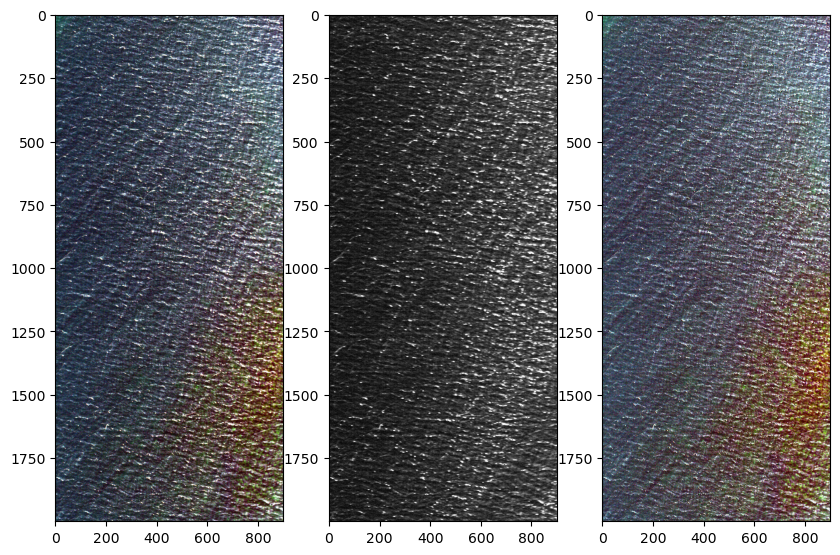

In [61]:
fig,ax = plt.subplots(ncols=3,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im_test[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_test_glint[:,:,rgb_ind]))
ax[2].imshow(image_render.percentile_stretch(im_test_noglint[:,:,rgb_ind]))
plt.show()